In [3]:
import os, sys
sys.path.append('./src')

import numpy as np

import torch
import torch.nn as nn
from torchmetrics.functional import accuracy, f1_score
from torchmetrics import ConfusionMatrix

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

# parameters and annotation 
from dataclasses import dataclass, field, asdict
from typing import Dict, Tuple

# Data Visualization
import pyvista as pv        
import pyvistaqt as pvqt
import matplotlib.pyplot as plt
import seaborn as sn
import ipywidgets as widgets
from IPython.display import (
    display,
    clear_output,
    HTML
)

# Logs and printing
import prettyprinter as pp
from prettytable import PrettyTable
# tensorboard? w&b? 

# Data Management
import h5py 
from src.data_preprocessing.dataset import MVDataset
from src.data_preprocessing.data_module import MVDataModule

# GATr layers: 
from src.GA_layers.Linears import (EquiLinear, Bilinear)                  
from src.GA_layers.Activatons import EquiGeLU
from src.GA_layers.NormLayers import EquiNormLayer
from src.GA_layers.Attentions import EquiMultiHeadAttention

# NonEqui MV_Layers
from NonEquiModel.NonEquiLin import NonEquiMVLinear
from NonEquiModel.NonEquiMultiHead import NonEquiChannelsAttention

from src.Utils.transformer_utils.PosEncoding import PositionalEncoding

# GATr utils
import src.Utils.geometric_utility as GA_utility
from src.Utils.equivariance_check import equivariance_check

# Generic setting:
pv.set_jupyter_backend('trame')     # data visualization
pp.install_extras(['dataclasses'])    # add support for dataclasses
pl.seed_everything(0)               # reproducibility

torch.set_float32_matmul_precision('medium')
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

@ TODO TODO TODO

 clone github

 unzip data

 mv the data to original dataset, then split it. 

In [ ]:
model_table = PrettyTable()
model_table.field_names = ["Model", "accuracy_test", "f1_test", "params numb", "equivariance", "epochs"]


# Intro, Data Analysis
- sub-section 1<br> 
 the next session of the notebook present the dataset,
 our task and analize the statistc of the dataset. 
- sub-section 2<br>
 It will also present the strategy of downsample of the dataset

The dataset used for this project comes directly from the original GATr research. Although, our task is substancially different respect the original one. 
In the original problem involving Arterias data, the goal was to estimate the wall-stress shread, a parameter of the deformation of the arteia through the effect of the bloody pressure. Such setting represent a standard regression problem. However, in this report, we face a more simpler problem of binary classification, separating the arteia between single corpus and bifurcated. 

Such classification result trivial, and can be solved without the use of deep learning. 
However, represent a great starting point for analyze geometric data. 
***
In the next cells you could <b>render any sample of the original dataset</b> by insert the id of the sample that you would visualize.
The dataset that will be loaded contains the original features for now, and it will be used only for an exploaration part.

In [4]:
# around 1 min for run: load the entire dataset 
# just for exploration purposes. This feature are not converted in the geometric algebra framework yet

path = 'datasets/original_datasets'
dataset = MVDataset()

# this contains raw data at the moment
dataset.load_data_files([os.path.join(path, file) for file in os.listdir(path) if file.endswith('.hdf5')])




<font color="8B0000">PS: 
after sub-sampling procude the dataset and converting all to a multivector format, the next cell cannot run anymore.
pls, do not run this cell after having apply the pre-processing
</font>

In [4]:

def render_sample(id: int):
    """render one sample of the dataset"""

        
    face = dataset.X[id]['face'].numpy()
    pos = dataset.X[id]['pos'].numpy()


    triangles = (np.ones(face.shape[0], dtype=np.int32)*3).reshape(-1, 1)

    face_mesh = np.concatenate((triangles, face), axis=-1)
    colors = torch.ones(pos.shape[0], 3)
    colors[dataset.X[id]['inlet_idcs']] = 0

    mesh = pv.PolyData(pos, face_mesh)
    mesh.point_data['inlet'] = colors
    plotter = pv.Plotter(notebook=True)
    plotter.add_mesh(mesh, scalars='inlet', show_edges=True)
    plotter.show(auto_close=True)
    plotter.close()
    return plotter

def callback(id):
    clear_output()
    display(input_box, button)
    plotter = render_sample(input_box.value)
    return plotter
#description_html = HTML("<p><b>Sample Visualization:</b> Select a sample ID and click 'Render' to visualize it." +
#                        "<br>The rendering is interactive, you can zoom in/out and rotate the view" +
#                        "<br><code>[Under 2000 are single, then bifurcating]<code></p>")
input_box = widgets.IntText(value=10, description='', min=0, max=dataset.__len__()-1)
button = widgets.Button(
    layout=widgets.Layout(width='50%', height='80px'),
    description='Render',
    button_style='info')  

button.on_click(callback)
#display(description_html, input_box, button)
display(input_box, button)
plotter = render_sample(0)



IntText(value=10)

Button(button_style='info', description='Render', layout=Layout(height='80px', width='50%'), style=ButtonStyle…

Widget(value='<iframe src="http://localhost:40865/index.html?ui=P_0x7eb540086f80_0&reconnect=auto" class="pyvi…

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 1894, in _run_once
    hand

: 

<h3>Data Exploration</h3>

Each patient sample contains 5 property:

- <b>position</b> : 3D vectors of float
- <b>pressure</b> : scalar value (float)
- <b>face</b>  : 3D vectors of int --> list of point
- <b>inlet</b> : 3D vectors of int --> list of point
- <b>wss</b>   : 3D vectors of float
***
<br>
The dataset contains substantially mesh data, where position is the 3D position of each node of the mesh, face represent the triplet of point that create each triangle on the mesh. 

Pressure is a scalar parameter that indicate the blood pressure in each point of the mesh, while wss represent the wall-stress-shared. This last feature comes as a 3D vector, and can be consider as a deformation respect the nominal positin (or a force apply at the relative position point).

The inlet list of point contains the position of the triangle from which the blood flow into the arteria. Altough this property was important for estimate the wss, in the binary classification result meaning-less, because or goal is reasoning over geometric entity. 

 

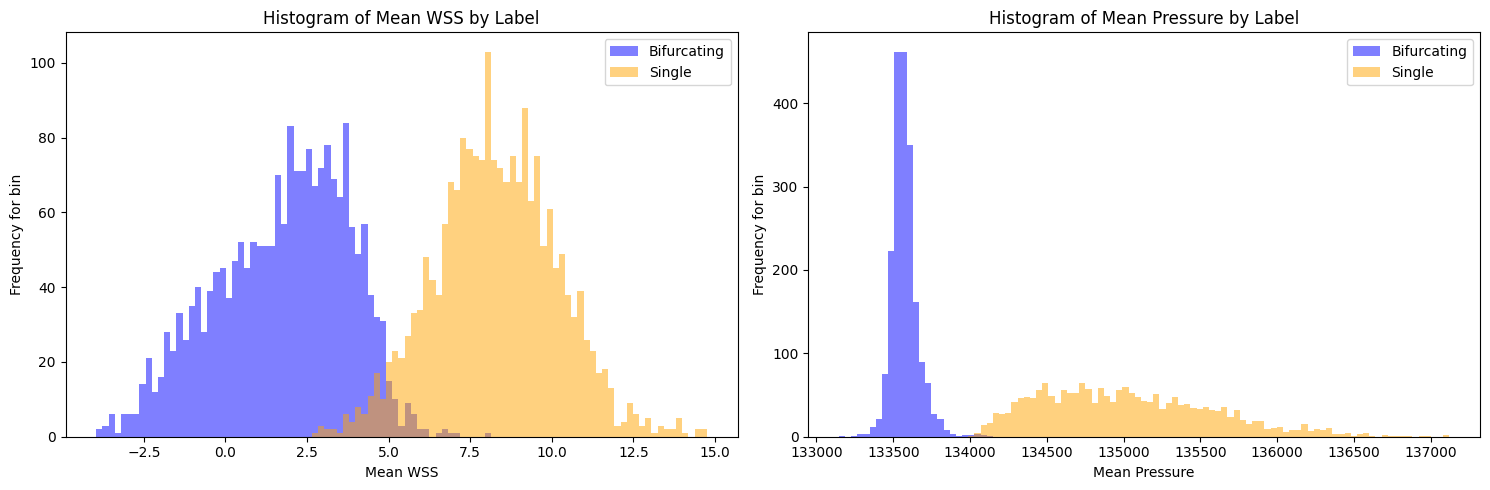

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the mean pressure and mean wss for each patient
mean_pressure_X = []
mean_wss_X = []
label_y = []

for i in range(dataset.__len__()):
    mean_pressure_X.append(dataset.X[i]['pressure'].mean().numpy())
    mean_wss_X.append(dataset.X[i]['wss'].mean().numpy())
    label_y.append(dataset.y[i].numpy())

# Convert to numpy format for plotting
mean_wss_X = np.array(mean_wss_X)
mean_pressure_X = np.array(mean_pressure_X)
label_y = np.array(label_y)

# Separate values based on labels
mean_wss_bif = mean_wss_X[label_y == 1]
mean_wss_single = mean_wss_X[label_y == 0]

mean_pressure_bif = mean_pressure_X[label_y == 1]
mean_pressure_single = mean_pressure_X[label_y == 0]

# Plot settings
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot for mean WSS
bins_wss = np.linspace(min(mean_wss_X), max(mean_wss_X), 100)
axes[0].hist(mean_wss_bif, bins=bins_wss, alpha=0.5, label='Bifurcating', color='blue')
axes[0].hist(mean_wss_single, bins=bins_wss, alpha=0.5, label='Single', color='orange')
axes[0].set_xlabel('Mean WSS')
axes[0].set_ylabel('Frequency for bin')
axes[0].legend(loc='upper right')
axes[0].set_title("Histogram of Mean WSS by Label")

# Plot for mean Pressure
bins_pressure = np.linspace(min(mean_pressure_X), max(mean_pressure_X), 100)
axes[1].hist(mean_pressure_bif, bins=bins_pressure, alpha=0.5, label='Bifurcating', color='blue')
axes[1].hist(mean_pressure_single, bins=bins_pressure, alpha=0.5, label='Single', color='orange')
axes[1].set_xlabel('Mean Pressure')
axes[1].set_ylabel('Frequency for bin')
axes[1].legend(loc='upper right')
axes[1].set_title("Histogram of Mean Pressure by Label")

plt.tight_layout()
plt.show()



We can also claim the just the mean pressure and the mean wss could be sufficient for classify all the arterias. Loggically, a bifurcating arteria will see a change of the pressure after the bifuraction. 
The wss parameters could be more tricky, due the fact that the wall-stress could be influenced also from any deformation of the canal. For verify this claim, we could plot the mean of each sequence of data for patient. In the next plots, we'll see a small overlap over the mean pressure, and a bigger confusion across the wss mean parameters.

However, combining the 2 feature risult in a quasi-linearly separable dataset:

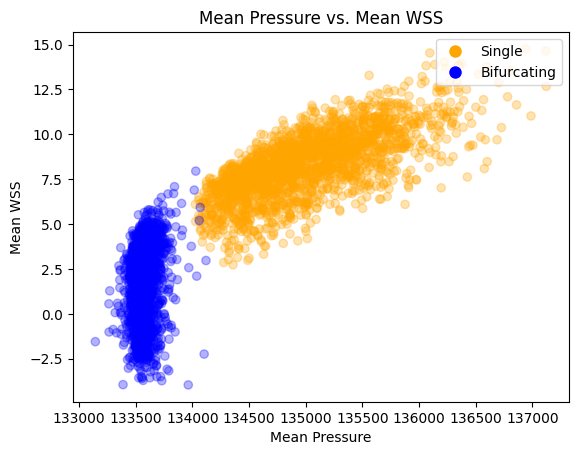

In [21]:
color_map = np.where(label_y == 0, 'orange', 'blue')  # orange for "Single", blue for "Bifurcating"
scatter = plt.scatter(mean_pressure_X, mean_wss_X, c=color_map, alpha=0.3)


plt.xlabel('Mean Pressure')
plt.ylabel('Mean WSS')
plt.title('Mean Pressure vs. Mean WSS')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Single'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Bifurcating')]
plt.legend(handles=handles, loc='upper right')

plt.show()


We should also consider that this feature are neither normalized. Another feature that could be discriminant for such task are the dispersion of the point cloud, analyzed in the next plot as variance of each sample

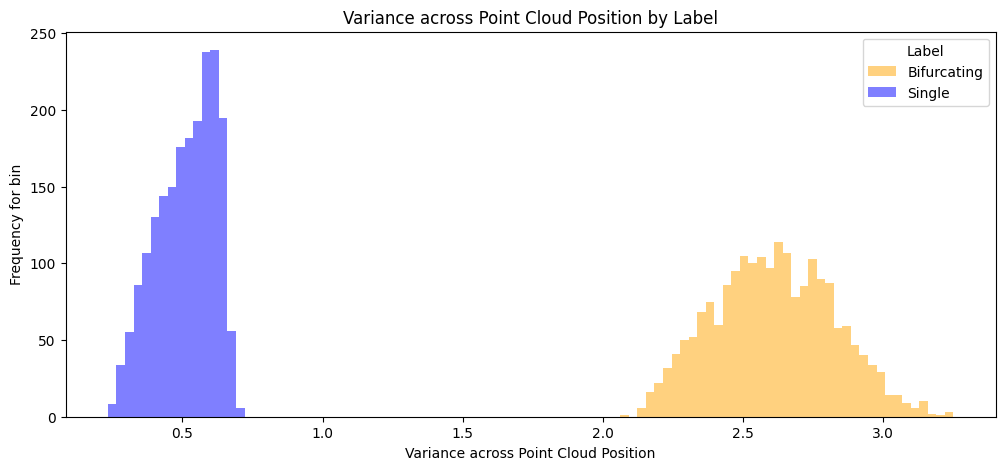

In [27]:
mean_pos_for_id = []
var_pos_for_id = []

for i in range(dataset.__len__()):
    var_pos_for_id.append(dataset.X[i]['pos'].var().numpy())

var_pos_for_id = np.array(var_pos_for_id)

var_pos_single = var_pos_for_id[label_y == 0]
var_pos_bif = var_pos_for_id[label_y == 1]

# Define bins for the histogram
bins_var_pos = np.linspace(min(var_pos_for_id), max(var_pos_for_id), 100)

# Plot histograms
plt.figure(figsize=(12, 5))
plt.hist(var_pos_single, bins=bins_var_pos, alpha=0.5, label='Bifurcating', color='orange')
plt.hist(var_pos_bif, bins=bins_var_pos, alpha=0.5, label='Single', color='blue')

# Adding labels, title, and legend
plt.xlabel("Variance across Point Cloud Position")
plt.ylabel("Frequency for bin")
plt.title("Variance across Point Cloud Position by Label")
plt.legend(title="Label")

plt.show()

All this for explain that the task itself is trivial, and does not require a complex architecture for obtain a top accuracy. Just for prove this, in the next section we'll a very smaller net that can reach across 97% of accuracy in few epochs, without any need for tuning

# Dummy classifier 
PS: if the accuracy does not go up to ~95%, just re-run the train. The number of iteration is pretty low, so a lot of the final result depend's on the inizialization of the parameters

In [29]:


class DummyClassifier(torch.nn.Module):
    def __init__(self):
        super(DummyClassifier, self).__init__()
        self.L1 = torch.nn.Linear(2, 30)
        self.L2 = torch.nn.Linear(30, 1)
        self.act = torch.nn.ReLU()
    
    def forward(self, x):
        h = self.act(self.L1(x))
        return (self.L2(h))
    


model = DummyClassifier().to(device)
cross_entropy = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())
epochs = 25_000

Xy = torch.stack((
    torch.from_numpy(mean_pressure_X), 
    torch.from_numpy(mean_wss_X),
    torch.from_numpy(label_y)
    ),
    dim=-1).to(device)
Xy = Xy[torch.randperm(Xy.shape[0])]

train_size = int(0.8*Xy.shape[0])
Xy_train, Xy_test = Xy[:train_size, :], Xy[train_size:, :]


for epoch in range(epochs):
    Xy_train = Xy_train[torch.randperm(Xy_train.shape[0])]
    X, y = Xy_train[:, :2], Xy_train[:, 2]
    optimizer.zero_grad()
    y_hat = model(X).squeeze(-1)
    loss = cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()

y_hat_test = torch.sigmoid(model(Xy_test[:, :2]).squeeze(-1))
y_hat_train = torch.sigmoid(model(Xy_train[:, :2]).squeeze(-1))

y_hat_test = (y_hat_test > 0.5).float()
y_hat_train = (y_hat_train > 0.5).float()

acc_train = accuracy(y_hat_train, Xy_train[:, 2], task='binary')
acc_test = accuracy(y_hat_test, Xy_test[:, 2], task='binary')
print(f"accuracy: train = {acc_train}, test = {acc_test},")

f1_test = f1_score(y_hat_test, Xy_test[:, 2], task='binary')
f1_train = f1_score(y_hat_train, Xy_train[:, 2], task='binary')

model_table.add_row([
    "dummyMlp",
    f"{(acc_test.item()):.5f}", 
    f"{(f1_test.item()):.5f}",
    sum([p.numel() for p in model.parameters()]),
    "no",
    epochs])

print("\n\n", model_table)

  

accuracy: train = 0.9646764397621155, test = 0.9649999737739563,


 +----------+---------------+---------+-------------+--------------+--------+
|  Model   | accuracy_test | f1_test | params numb | equivariance | epochs |
+----------+---------------+---------+-------------+--------------+--------+
| dummyMlp |    0.96500    | 0.96610 |     121     |      no      | 25000  |
+----------+---------------+---------+-------------+--------------+--------+


# Dealing with geometry: The PGA framework and his advantage  



The beautifull world of Geometric Algebra is a concrete alterganive to the standard vector algebra. In this strange world, the high level mathematics became simple and the simple operation became complex. It's capable to unify different subspace and reduce the number of operation needed in modern dynamics.

All the object are embedded in <code>MultiVector</code>, a sum of abstract element. This Multivector contains element that could not be summed between them, but we conventionally write as a sum of this sub-element (exactly how we deal with imagginary numbers.)

The GA "flavours" that we use in this project is the 3D PGA : $G \{3, 0, 1\}$, The 3 number represent the number of basis vector that square respectvly to 1, -1, 0.  <br>
***
The PGA , as any instance of a projective algebra, preserv the intersection of object when apply the different group operation. And we can also see that any object in the framework are represent as a intersection of the main element of the group. Such element in the 3D instance of PGA are represent by a 3D plane.

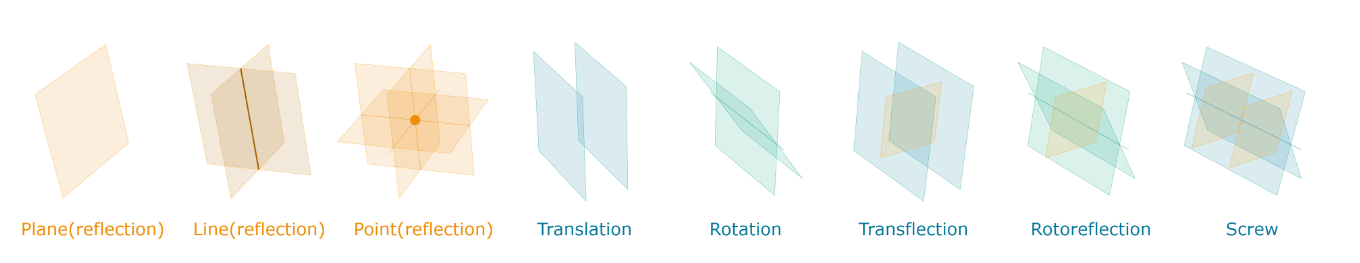

***
Also, as we can see from the previous image, all the Euclidian transformation are created by composition of translation.

As wee can see, the plane is the basic element of such framework, and we represent this by a basis vector $e_{i = 0, 1, 2, 3}$. The composition of 2 plane generate a so call <code>BiVector</code> : $e_{ij}$, the composition of 3 plane generate a point, also call <code>TriVector</code>  $e_{ijk}$

Other element of such geometry are the <code>PseudoScalar</code> $e_{ijkv} = I$, and the <code>Scalar</code>, represented as the val $1$. 

All this object are represent in the following table, whis his squared value:
<br><br>
![basis and square basis.png](<attachment:basis and square basis.png>)

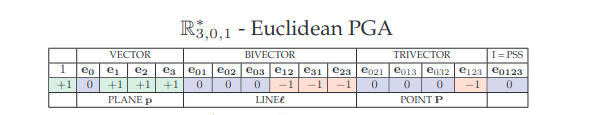

# Why use a GA framework in the Geometric Deep Learning Framework

A geometric deep learning framework is a field that explore simmetry and equivariance proprerty of our data. 
The symmetry prior that we want to enforce is captured by the Transformation in SE(3). Such transformation, such rotation and translation (and also reflection), in the geometric algebra framework are rapresented by a simple composition of reflection. 

The essence of our group is capture by the group action and representation, and this is the why behind the choice of encapsulate the data in the GA framework. The generic formula for apply any group action is the Sandwich product, defined as :

$\rho_u(x)= \begin{cases}u x u^{-1} & \text { if } u \text { is even } \\ u \hat{x} u^{-1} & \text { if } u \text { is odd }\end{cases}$

Where $\rho_u(x)$ is the action representation of $u$, applied at the multivector $x$. Such transformation comes from the so call SPIN Group.

Any transformation of the SPIN group are created as another multivector, following the previous table. 

In general, we could also consider such group contains all the reflection and the <code>Motors</code>  of our Geom.Algebra. Here a recap of each representation:
<br><br>
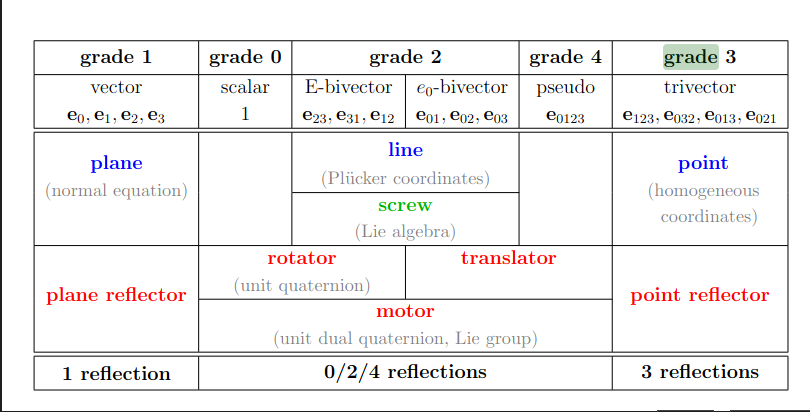

# SubSample Strategy

Each patient has, offcourse, a different arteria. The result in a different number of point for each mesh. <br>
This numer of point is in any case pretty huge, much more than a standard context window of a transformer model. <br> 
For this reasoning, i subsample all the category of the dataset using different indeces. <br>
The resulting arteria sample will contains N points, N different faces, N pressures value and N wss value.<br>
Each of this data will be encoded in a different channels of my input tensor.<br>
<br>
ps: Talking about tensor is not correctly, becuse the sub-sample are store in a list for handle the conversion to multivectors data (see next cells for details)

In [10]:
""" 
just for show how sub-sample the dataset
 the n_samples parameters select how many sample extract from each patient.
 the n_resampling parameters can be view as a data augmentation parameters

 --> by resampling, we generate a different point cloud for each arteria, resulting
 --> in a different input set

"""

# ps: increasing the number of sample increase the time needed for run this cell
# can be done, but be aware the the time can grow (n_sample=50 ~ 8 minutes)
# after the sub-sampling and the conversion to multivector, the tensor are saved in a new file 
# we will use this new file in the training, for speed up the pre-processing
dataset.sub_sample_data(
    n_samples=1,
    n_resempling=1
    )


# MultiVector conversion 

a double stage procedure is needed for converting the raw data into a multivector. First, a conversion to a pure geometric representation, and then an encoding in the multivector format.
Both operation are done internally to the dataset class.

In [11]:
# convert the list of data to a single tensor
dataset.convert_to_mv()

# if needed, save the dataset tensor and the class parameters by:
# dataset.save_data('datasets/converted_datasets')
# (this will generate 2 tensor, X, y, and a pickle object contains the class parameters)


The previous line invoke a routine for convert the "face" variable into a plane representation (norm, displacement). <br>
The other variable are encoded following this scheme:

- position : 3D point
- face : 3D plane
- wss: transflation 
- pressure: scalar

Also, the data are embedded using this table: 
<br><br>
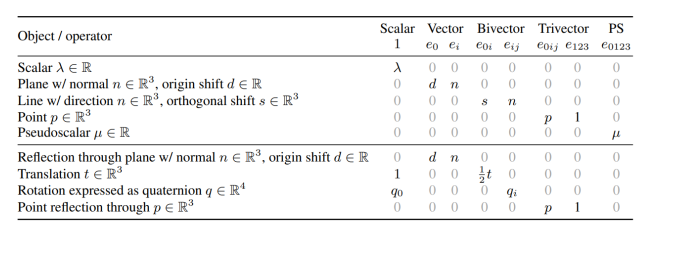

<br>
for any details about the implementations, please refere to the MVDataset Class itself (src folder)

# BASE Line: non-equivariant MultiVect Transformer

What happend if we do not enforce the symmetry property of the GA into our transformer? A baseline method selected for see what are the advantage of this encapsulation is a standard encoder with fully connected linear mapping between the different channels. Also, for let the attention mechanism work on the multi-channels, we rely on the Axial attention paper as a possible solution. 

In this architecture, the attention is calculate across each channels indipendently, and then the contribut of each channels is combined in the output.


The linear layer underline a linear mapping that consider all the different multivector component following the standard paradigm:
$$ y_{out_c, j} = \sum_{i=0}^{16} w_{out_c, in_c, i} \cdot x_{in_c, i}$$
The weight matrix of this linear layer became a 3D tensor of shape <code>[out_channels, in_channels, 16]</code>

In [11]:
@dataclass
class MVTransformerParameters:


    """ MODEL PARAMETERS """

    hidden_channels: int = 4     # number of starting channels
    
    n_heads: int = 4                        # number of heads in multihead attention
    n_blocks: int = 2                       # number of GATr blocks

    normLayer_dim : Tuple[int, int] = (16, hidden_channels)
    
    """ TRAINING PARAMETERS """

    batch_size: int = 8
    learning_rate: float = 0.001    # adam learning rate
    weight_decay: float = 0.0       # adam weight decay

    max_epochs: int = 10            # number of epochs
    
    load_weights: bool = False      # if True, the model will load the weights
    weights_path: str = None        # path to the weights to load

    grade_track_norm: int = 0       # the l-norm of the grad to track, None for not tracking
    gradient_clip_val: float = 0.1  # gradient clipping value,         None for not clipping

    """ DATA PARAMETERS """

    datasets_path: str = "datasets"   # path to the datasets
    load_dataset: bool = True         # if True, the model will load the dataset in the MV format
    n_samples: int = 200              # number of samples in the dataset
    n_resempling: int = 1             # number of resempling of the dataset
    sequence_len: int = n_samples * n_resempling    # number of element in a sequence
    selected_featured: Dict[str, bool] = field(
        default_factory=lambda:{
            'wss': True, 
            'pos': True, 
            'pressure': True, 
            'inlet': False, 
            'face': True
    })
    """ GENERIC """
    device: torch.device = device   # device automatically setted 
    MV_dim: int = 16                # mutlivector dimension --> in 3D PGA: 16


MVTransf_parameters = MVTransformerParameters() 

In [12]:
class MVTransformerBlock(nn.Module):


    def __init__(self, params):
        super(MVTransformerBlock, self).__init__()

        # pos encoder is added before
        
        self.first_sub_block = nn.Sequential(
            NonEquiChannelsAttention(params.hidden_channels, params.hidden_channels, params.n_heads),
            nn.LayerNorm(params.MV_dim, params.n_samples),
        )
        self.second_sub_block = nn.Sequential(
            NonEquiMVLinear(params.hidden_channels, params.hidden_channels),
            NonEquiMVLinear(params.hidden_channels, params.hidden_channels),
            nn.LayerNorm(params.MV_dim, params.n_samples)
        )

    def forward(self, x):
        sub_step = self.first_sub_block(x) + x
        return self.second_sub_block(sub_step) + sub_step

MVTransformerBlock(MVTransf_parameters)

MVTransformerBlock(
  (first_sub_block): Sequential(
    (0): NonEquiChannelsAttention(
      (Q_proj): NonEquiMVLinear()
      (K_proj): NonEquiMVLinear()
      (V_proj): NonEquiMVLinear()
      (out_proj): NonEquiMVLinear()
    )
    (1): LayerNorm((16,), eps=200, elementwise_affine=True)
  )
  (second_sub_block): Sequential(
    (0): NonEquiMVLinear()
    (1): NonEquiMVLinear()
    (2): LayerNorm((16,), eps=200, elementwise_affine=True)
  )
)

In [13]:
class MVTransformer(pl.LightningModule):

    def __init__(self, params):
        super(MVTransformer, self).__init__()

        self.pos_enc =  PositionalEncoding(params.MV_dim, params.n_samples, device=device)
        
        self.Encoder = nn.Sequential(
            *[MVTransformerBlock(params) for _ in range(params.n_blocks)]
        )
        self.output_layer = NonEquiMVLinear(
            params.hidden_channels, 
            1
        )
        
        self.classifier = nn.Linear(params.MV_dim, 1)
        
        self.confusion_matrix = ConfusionMatrix('binary')

        self.criterion = nn.BCEWithLogitsLoss()

        self.batch_size = params.batch_size
        self.lr = params.learning_rate
        self.weight_decay = params.weight_decay
    
    def forward(self, x):
        
        # first linear projection
        x = self.pos_enc(x)
        
        # pass across the attention block
        x = self.Encoder(x)
        
        # output projection and mean pooling
        x = self.output_layer(x).squeeze(-2).mean(-2)

        logit = self.classifier(x) 
        
        return logit
        
    def training_step(self, batch):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1) 
        loss = self.criterion(y_hat, y)
        self.log('train loss', loss, on_epoch=True)
        return loss        
    
    def validation_step(self, batch):
        x, y = batch

        y_hat = self.forward(x).squeeze(-1) # return logit
        
        loss = self.criterion(y_hat, y) 

        acc = accuracy(y_hat, y, task='binary')
        
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        self.log('val loss', loss, on_epoch=True, prog_bar=True)
        
        log_dict = dict({
            'val_loss': loss,
            'val_acc': acc
        })
        
        return log_dict
    
    def test_step(self, batch):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        loss = self.criterion(y_hat, y)

        acc = accuracy(y_hat, y, task='binary')

        self.confusion_matrix.update(y_hat, y)
        self.log('test_acc', acc, on_epoch=True, prog_bar=True)

        log_dict = dict({
            'test_loss': loss,
            'test_acc': acc,
        })
        return log_dict

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    

In [14]:

data_module = MVDataModule(
    datasets_path=MVTransf_parameters.datasets_path, 
    load_dataset=MVTransf_parameters.load_dataset,
    n_samples=MVTransf_parameters.n_samples,  
    n_resempling=MVTransf_parameters.n_resempling,
    batch_size=MVTransf_parameters.batch_size
)



baseline = MVTransformer(MVTransf_parameters).to(device)
trainer = pl.Trainer(
    logger=CSVLogger('logs', name='GATrClassifier'),
    max_epochs=MVTransf_parameters.max_epochs,
    gradient_clip_val=MVTransf_parameters.gradient_clip_val
    
)

trainer.fit(baseline, data_module)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                  | Params
-----------------------------------------------------------
0 | pos_enc          | PositionalEncoding    | 0     
1 | Encoder          | Sequential            | 11.3 K
2 | output_layer     | NonEquiMVLinear       | 80    
3 | classifier       | Linear                | 17    
4 | confusion_matrix | BinaryConfusionMatrix | 0     
5 | criterion        | BCEWithLogitsLoss     | 0     
-----------------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.045     Total estimated model params size (MB)


DATASET LOADED IN MV FORMAT FROM : /home/dema/Project/GAT/datasets/train/


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [15]:
data_module.setup('test')
test_dataloader = data_module.test_dataloader()
test_log = trainer.test(baseline, test_dataloader, verbose=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


DATASET LOADED IN MV FORMAT FROM : /home/dema/Project/GAT/datasets/test/
DATASET LOADED IN MV FORMAT FROM : /home/dema/Project/GAT/datasets/test/


/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

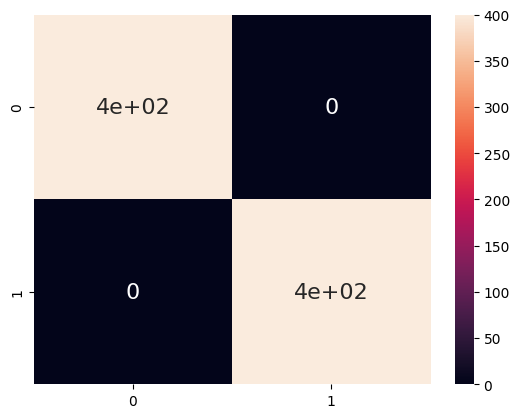

In [16]:
conf_matrix = baseline.confusion_matrix.compute().detach().cpu().numpy()
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 16})
plt.show()

In [17]:
# f1 comp 
TP, TN = conf_matrix[0, 0], conf_matrix[1, 1]
FP, FN = conf_matrix[0, 1], conf_matrix[1, 0]

f1_test_baseline = 2*TP / (2*TP + FP + FN)

In [18]:
model_table.add_row([
    baseline.__class__.__name__, 
    test_log[0]['test_acc'],
    f1_test_baseline,
    sum([p.numel() for p in baseline.parameters()]),
    "no",
    MVTransf_parameters.max_epochs

])
print(model_table)

+---------------+---------------+---------+-------------+--------------+--------+
|     Model     | accuracy_test | f1_test | params numb | equivariance | epochs |
+---------------+---------------+---------+-------------+--------------+--------+
|    dummyMlp   |    0.96500    | 0.96610 |     121     |      no      | 25000  |
| MVTransformer |      1.0      |   1.0   |    11361    |      no      |   10   |
+---------------+---------------+---------+-------------+--------------+--------+


# EQUIVARIANCE RESULTS

Let's see what are the error (in terms of equivariance) of such model

In [31]:
SPIN_GROUP_OPERATOR = [
    'translation',
    'rotation',
    'point reflection',
    'plane reflection'
]

def update_equivariance_log_table(x, layer, table, divider=False):

    avg_deltas = []
    for transformation in SPIN_GROUP_OPERATOR:
        Ty, yT = equivariance_check(x, layer, transformation, return_val=True, device=device)
        avg_deltas.append(f"{((Ty - yT).mean().item()):.5f}")

    table.add_row([
        str(layer.__class__.__name__),
        *avg_deltas,
    ],
    divider=divider)
    
    return table

In [32]:
# For this part of the notebook we don't need any grad
torch.set_grad_enabled(False) 

# Let's mimic a random batch for a multivector
# [batch, seq_len, channels, mv_dim]
x = torch.randn(32, 30, 4, 16).to(device)

# create table for store our results
table = PrettyTable(
        field_names=['layer', 'translation', 'rotation', 'point reflection', 'plane reflection']
)


# NON EQUIVARIANT LAYERS
table.add_row(['Non Equivariant Layers', *['.' for i in range(4)]], divider=True)
nonEqui_linear = NonEquiMVLinear(in_channels=4, 
                                out_channels=4).to(device)
nonEqui_MultiHead = NonEquiChannelsAttention(in_channels=4,
                                             out_channels=4,
                                             n_heads=4).to(device)

update_equivariance_log_table(x, nonEqui_MultiHead, table)
update_equivariance_log_table(x, nonEqui_linear, table, divider=True)

print(table)

+--------------------------+-------------+----------+------------------+------------------+
|          layer           | translation | rotation | point reflection | plane reflection |
+--------------------------+-------------+----------+------------------+------------------+
|  Non Equivariant Layers  |      .      |    .     |        .         |        .         |
+--------------------------+-------------+----------+------------------+------------------+
| NonEquiChannelsAttention |   0.09029   | -0.01199 |     0.42956      |     -0.32169     |
|     NonEquiMVLinear      |   0.21667   | -0.04006 |     -0.02628     |     0.18870      |
+--------------------------+-------------+----------+------------------+------------------+


# GATr training

As before, a set of parameters are shown here for display the general structure of the GATr parameters. However, after the optimization trial running by optuna in the future cell, the parameters have been saved in a file under <code>src/parameters/Equi/GATrParameters.py</code>

In the nexts cells, we also import that set of parameters for a fast training

In [2]:
""" define all the parameters of the models and the training process """

@dataclass
class Parameters:


    """ MODEL PARAMETERS """

    inputLayer_input_channels: int =  4     # number of starting channels
    inputLayer_output_channels: int = 8     # number of first hidden channels

    hiddenLayer_channels: int = 16          # number of hidden channels of GATr block
    
    n_heads: int = 1                  # number of heads in multihead attention
    n_blocks: int = 1                       # number of GATr blocks

    outputLayer_output_channels: int = 1    # number of output channels
    

    """ TRAINING PARAMETERS """

    batch_size: int = 8
    learning_rate: float = 1e-5    # adam learning rate
    weight_decay: float = 0.001       # adam weight decay

    max_epochs: int = 10           # number of epochs
    
    load_weights: bool = False      # if True, the model will load the weights
    weights_path: str = None        # path to the weights to load

    grade_track_norm: int = 0       # the l-norm of the grad to track, None for not tracking
    gradient_clip_val: float = 0.1  # gradient clipping value,         None for not clipping

    """ DATA PARAMETERS """

    datasets_path: str = "datasets"   # path to the datasets
    load_dataset: bool = True         # if True, the model will load the dataset in the MV format
    n_samples: int = 200              # number of samples in the dataset
    n_resempling: int = 1             # number of resempling of the dataset
    sequence_len: int = n_samples * n_resempling    # number of element in a sequence
    selected_featured: Dict[str, bool] = field(
        default_factory=lambda:{
            'wss': True, 
            'pos': True, 
            'pressure': True, 
            'inlet': False, 
            'face': True
    })
    """ GENERIC """
    device: torch.device = device   # device automatically setted 
    MV_dim: int = 16                # mutlivector dimension --> in 3D PGA: 16

parameters = Parameters()

NameError: name 'device' is not defined

True

In [2]:
from src.parameters.Equi.GATrParameters import Parameters
parameters = Parameters()
pp.pprint(asdict(parameters))

{
    'inputLayer_input_channels': 4,
    'inputLayer_output_channels': 8,
    'hiddenLayer_channels': 16,
    'n_heads': 1,
    'n_blocks': 1,
    'outputLayer_output_channels': 1,
    'batch_size': 8,
    'learning_rate': 1e-05,
    'weight_decay': 0.001,
    'max_epochs': 10,
    'load_weights': False,
    'weights_path': None,
    'grade_track_norm': 0,
    'gradient_clip_val': 0.1,
    'datasets_path': 'datasets',
    'load_dataset': True,
    'n_samples': 200,
    'n_resempling': 1,
    'sequence_len': 200,
    'selected_featured': {
        'wss': True,
        'pos': True,
        'pressure': True,
        'inlet': False,
        'face': True
    },
    'device': 'cuda',
    'MV_dim': 16
}


In [38]:
parameters._

{'inputLayer_input_channels': Field(name='inputLayer_input_channels',type=<class 'int'>,default=4,default_factory=<dataclasses._MISSING_TYPE object at 0x7604649f9d80>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 'inputLayer_output_channels': Field(name='inputLayer_output_channels',type=<class 'int'>,default=8,default_factory=<dataclasses._MISSING_TYPE object at 0x7604649f9d80>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 'hiddenLayer_channels': Field(name='hiddenLayer_channels',type=<class 'int'>,default=16,default_factory=<dataclasses._MISSING_TYPE object at 0x7604649f9d80>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 'n_heads': Field(name='n_heads',type=<class 'int'>,default=1,default_factory=<dataclasses._MISSING_TYPE object at 0x7604649f9d80>,init=True,repr=True,hash=None,compare=True,metadata=mappingprox

In [20]:

data_module = MVDataModule(
    datasets_path=parameters.datasets_path, 
    load_dataset=parameters.load_dataset,
    n_samples=parameters.n_samples,  
    n_resempling=parameters.n_resempling,
    batch_size=parameters.batch_size
)


In [21]:
data_module.setup('fit')

DATASET LOADED IN MV FORMAT FROM : /home/dema/Project/GAT/datasets/train/


In [22]:
class GATrBlock(nn.Module):

    def __init__(self, params):
        super(GATrBlock, self).__init__()
        
        self.sub_module_block1 = nn.Sequential(
            EquiNormLayer(),
            EquiLinear(params.inputLayer_output_channels, params.hiddenLayer_channels),
            PositionalEncoding(seq_len=params.sequence_len, emb_dim=16, device=device), 
            EquiMultiHeadAttention(n_head=params.n_heads, hidden_channels=params.hiddenLayer_channels),
            EquiLinear(params.hiddenLayer_channels, params.inputLayer_output_channels)
        )
        # then residual sum 1
        self.sub_module_block2 = nn.Sequential(
            EquiNormLayer(),
            EquiLinear(params.inputLayer_output_channels, params.hiddenLayer_channels),
            Bilinear(params.hiddenLayer_channels, params.hiddenLayer_channels),
            EquiGeLU(),
            EquiLinear(params.hiddenLayer_channels, params.inputLayer_output_channels)
        )
        # then residual sum 2
    
    def forward(self, x):
        out1 = self.sub_module_block1(x) + x
        out2 = self.sub_module_block2(out1) + out1
        return out2 


In [23]:
gat = GATrBlock(parameters)
for name, param in gat.sub_module_block1.named_parameters():
        print(f"Layer: {name} | Size: {param.size()} | Requires Grad: {param.requires_grad}")

Layer: 1.weight_Mv | Size: torch.Size([16, 8, 9]) | Requires Grad: True
Layer: 3.qkv_layer.weight_Mv | Size: torch.Size([48, 16, 9]) | Requires Grad: True
Layer: 3.out_proj.weight_Mv | Size: torch.Size([16, 16, 9]) | Requires Grad: True
Layer: 4.weight_Mv | Size: torch.Size([8, 16, 9]) | Requires Grad: True


In [24]:
class GATr(nn.Module):

    def __init__(self, params):
        super(GATr, self).__init__()
        
        # LAYERS

        # input
        self.input_layer = EquiLinear(params.inputLayer_input_channels, params.inputLayer_output_channels)
        
        
        # GATr blocks
        blocks = [GATrBlock(params) for _ in range(params.n_blocks)]
        self.blocks = nn.Sequential(*blocks)
                
        # final projection
        self.output_layer = EquiLinear(params.inputLayer_output_channels, params.outputLayer_output_channels)

        # LOADING WEIGHTS
        if params.load_weights:
            self.load_state_dict(torch.load(params.weights_path))
        


    def forward(self, x):
        x = self.input_layer(x)
        x = self.blocks(x)
        return self.output_layer(x)
    

In [26]:
class GATrClassifierLightning(pl.LightningModule):

    def __init__(self, parameters):

        super(GATrClassifierLightning, self).__init__()

    
        self.gatr_backbone = GATr(parameters).to(parameters.device)
        self.classifier = nn.Linear(parameters.MV_dim, 1)

        self.criterion = nn.BCEWithLogitsLoss()

        self.batch_size = parameters.batch_size
        self.lr = parameters.learning_rate
        self.weight_decay = parameters.weight_decay

        self.confusion_matrix = ConfusionMatrix(task='binary')


    def forward(self, x):
        
        # forward step on the gatr
        out_gatr = self.gatr_backbone(x)   # return [batch, seq_len, channels(1), 16]
        
        # mean pooling over sequence:
        pooling = out_gatr.squeeze(-2).mean(-2) # return [batch, 16]
        
        # classifier
        logit = self.classifier(pooling)
        return logit
    
    
    def training_step(self, batch):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        loss = self.criterion(y_hat, y)
        self.log('train loss', loss, on_epoch=True)

        return loss        
    
    def validation_step(self, batch):
        x, y = batch

        y_hat = self.forward(x).squeeze(-1)
        
        loss = self.criterion(y_hat, y)
        acc = accuracy(y_hat, y, task='binary')
        
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        self.log('val loss', loss, on_epoch=True, prog_bar=True)
        
        log_dict = dict({
            'val_loss': loss,
            'val_acc': acc
        })
        
        return log_dict
    
    def test_step(self, batch):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        loss = self.criterion(y_hat, y)

        self.confusion_matrix.update(y_hat, y)
        acc = accuracy(y_hat, y, task='binary')

        self.log('test_acc', acc, on_epoch=True, prog_bar=True)
        log_dict = dict({
            'test_loss': loss,
            'test_acc': acc, 
        })
        return log_dict

    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

In [44]:
gatrLight = GATrClassifierLightning(parameters).to(device)
trainer = pl.Trainer(
    logger=CSVLogger('logs', name='GATrClassifier'),
    max_epochs=parameters.max_epochs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
trainer.fit(gatrLight, data_module)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                  | Params
-----------------------------------------------------------
0 | gatr_backbone    | GATr                  | 37.2 K
1 | classifier       | Linear                | 17    
2 | criterion        | BCEWithLogitsLoss     | 0     
3 | confusion_matrix | BinaryConfusionMatrix | 0     
-----------------------------------------------------------
37.2 K    Trainable params
0         Non-trainable params
37.2 K    Total params
0.149     Total estimated model params size (MB)


DATASET LOADED IN MV FORMAT FROM : /home/dema/Project/GAT/datasets/train/


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [48]:
data_module.setup('test')   
test_log = trainer.test(gatrLight, data_module.test_dataloader(), verbose=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


DATASET LOADED IN MV FORMAT FROM : /home/dema/Project/GAT/datasets/test/
DATASET LOADED IN MV FORMAT FROM : /home/dema/Project/GAT/datasets/test/


/home/dema/Project/GAT/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

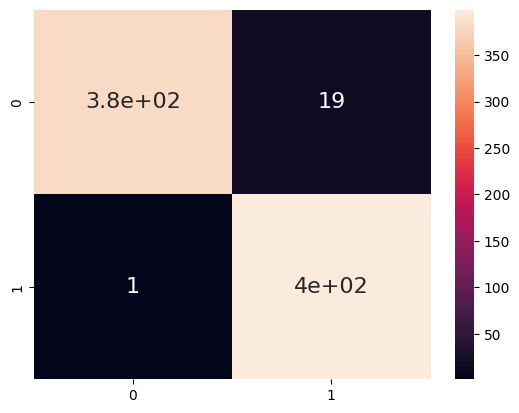

In [49]:
conf_matrix = gatrLight.confusion_matrix.compute().detach().cpu().numpy()
sn.heatmap(conf_matrix, annot=True, annot_kws={"size": 16})
plt.show()

In [50]:
# f1 comp 
TP, TN = conf_matrix[0, 0], conf_matrix[1, 1]
FP, FN = conf_matrix[0, 1], conf_matrix[1, 0]

f1_test_GAT = 2*TP / (2*TP + FP + FN)
model_table.add_row([
    gatrLight.__class__.__name__, 
    test_log[0]['test_acc'],
    f1_test_GAT,
    sum([p.numel() for p in gatrLight.parameters()]),
    "yes",
    MVTransf_parameters.max_epochs

])
print(model_table)

+-------------------------+--------------------+--------------------+-------------+--------------+--------+
|          Model          |   accuracy_test    |      f1_test       | params numb | equivariance | epochs |
+-------------------------+--------------------+--------------------+-------------+--------------+--------+
|         dummyMlp        |      0.96500       |      0.96610       |     121     |      no      | 25000  |
|      MVTransformer      |        1.0         |        1.0         |    11361    |      no      |   10   |
| GATrClassifierLightning | 0.9925000071525574 | 0.9924433249370277 |    37241    |      no      |   10   |
| GATrClassifierLightning | 0.9925000071525574 | 0.9924433249370277 |    37241    |      no      |   10   |
| GATrClassifierLightning | 0.9925000071525574 | 0.9924433249370277 |    37241    |      no      |   10   |
| GATrClassifierLightning | 0.9925000071525574 | 0.9924433249370277 |    37241    |      no      |   10   |
| GATrClassifierLightning | 

Let's see how such model perform considering our equivaraince test:

In [34]:

table.add_row(['Equivariant Layers', *['.' for i in range(4)]], divider=True)

# Instanciate single layer of GATr
equi_lin = EquiLinear(in_channels=4, out_channels=4).to(device)
bilinear = Bilinear(in_channels=4, out_channels=4).to(device)
gated_gelu = EquiGeLU().to(device)
equi_norm = EquiNormLayer().to(device)
equi_attention = EquiMultiHeadAttention(n_head=2, hidden_channels=4).to(device)

# update table by running the equivariance test
update_equivariance_log_table(x, equi_lin, table)
update_equivariance_log_table(x, bilinear, table)
update_equivariance_log_table(x, gated_gelu, table)
update_equivariance_log_table(x, equi_norm, table)
update_equivariance_log_table(x, equi_attention, table, divider=True)
print(table)


+--------------------------+-------------+----------+------------------+------------------+
|          layer           | translation | rotation | point reflection | plane reflection |
+--------------------------+-------------+----------+------------------+------------------+
|  Non Equivariant Layers  |      .      |    .     |        .         |        .         |
+--------------------------+-------------+----------+------------------+------------------+
| NonEquiChannelsAttention |   0.09029   | -0.01199 |     0.42956      |     -0.32169     |
|     NonEquiMVLinear      |   0.21667   | -0.04006 |     -0.02628     |     0.18870      |
+--------------------------+-------------+----------+------------------+------------------+
|    Equivariant Layers    |      .      |    .     |        .         |        .         |
+--------------------------+-------------+----------+------------------+------------------+
|        EquiLinear        |   -0.00000  | 0.00001  |     -0.00002     |     -0.